In [ ]:
# Importing Libraries
import pandas as pd
import numpy as np
import re
import spacy
from sentence_transformers import SentenceTransformer

from sklearn.model_selection import StratifiedKFold, cross_validate, cross_val_predict
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    make_scorer, accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)

# Load Training Data
from google.colab import files
uploaded = files.upload()

df = pd.read_excel("512_each_statements_nonstatements_chunks.xlsx")

# Identify text column, force string
text_col = 'text' if 'text' in df.columns else df.columns[0]
df[text_col] = df[text_col].astype(str)

# Ensure label exists and is 0/1
assert "label" in df.columns, "Expected a 'label' column with 0/1."
texts = df[text_col].tolist()
y = np.array(df["label"].tolist(), dtype=int)

# Load Models
nlp = spacy.load("en_core_web_sm")
sbert = SentenceTransformer("all-MiniLM-L6-v2")

Saving 512_each_statements_nonstatements_chunks.xlsx to 512_each_statements_nonstatements_chunks.xlsx


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
# Feature Engineering
def extract_features(text):
    doc = nlp(text)
    pos_tags = [token.pos_ for token in doc]

    return {
        "starts_with_modal": int(bool(re.match(r"^(should|must|can|will|would|shall)\b", text.lower()))),
        "contains_question_mark": int("?" in text),
        "length_tokens": len(text.split()),
        "contains_numbers": int(bool(re.search(r"\d", text))),
        "starts_with_amendment_term": int(bool(re.match(r"^(amendment|clause|section)\b", text.lower()))),
        "has_actor_reference": int(bool(re.search(r"\b(we|government|minist(er|ry))\b", text.lower()))),
        "has_modal_verb": int(bool(re.search(r"\b(should|must|can|could|might|will|shall|would|may)\b", text.lower()))),
        "has_adj_or_adv": int("ADJ" in pos_tags or "ADV" in pos_tags)
    }


In [ ]:
# Extract Features
feature_df = pd.DataFrame([extract_features(t) for t in texts])
feature_cols = feature_df.columns.tolist()

# SBERT Embeddings
embeddings = sbert.encode(texts, show_progress_bar=True)
embeddings = np.asarray(embeddings, dtype=np.float32)

# L2-normalise embeddings
embeddings = normalize(embeddings, norm="l2")

# Standardise Features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(feature_df.values.astype(np.float32))

# Combine
X_combined = np.hstack([embeddings, features_scaled])

# CV Setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Defining Scoring Metrics
scoring = {
    "accuracy": "accuracy",
    "precision_statement": make_scorer(precision_score, pos_label=1),
    "recall_statement": make_scorer(recall_score, pos_label=1),
    "f1_statement": make_scorer(f1_score, pos_label=1),
    "f1_macro": "f1_macro",
}


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

In [ ]:
# Making the MLP
mlp = MLPClassifier(
    hidden_layer_sizes=(256,),
    activation="relu",
    solver="adam",
    alpha=0.001,
    learning_rate_init=0.001,
    max_iter=500,
    early_stopping=True,
    validation_fraction=0.1,
    random_state=42
)

# Cross Validated Metrics
print("\nRunning 5-fold cross-validation...")
cv_results = cross_validate(
    mlp, X_combined, y, cv=cv, scoring=scoring, return_train_score=False, n_jobs=-1
)

print("\nCV mean ± std (5-fold):")
for k in ["test_accuracy", "test_precision_statement", "test_recall_statement", "test_f1_statement", "test_f1_macro"]:
    mean_k = np.mean(cv_results[k])
    std_k = np.std(cv_results[k])
    print(f"{k.replace('test_', ''):>22}: {mean_k:.3f} ± {std_k:.3f}")

# Out of fold predictions and confusion matrix
print("\nGenerating out-of-fold predictions for confusion matrix & error inspection...")
y_pred_oof = cross_val_predict(mlp, X_combined, y, cv=cv, n_jobs=-1)

cm = confusion_matrix(y, y_pred_oof, labels=[0, 1])
tn, fp, fn, tp = cm.ravel()

print("\nOut-of-fold confusion matrix (rows=true, cols=pred):")
print(cm)
print(f"\nFalse positives (non-statement → statement): {fp}")
print(f"False negatives (statement → non-statement): {fn}")

print("\nClassification report (OOF):")
print(classification_report(y, y_pred_oof, target_names=["non-statement", "statement"]))



Running 5-fold cross-validation...

CV mean ± std (5-fold):
              accuracy: 0.860 ± 0.015
   precision_statement: 0.845 ± 0.014
      recall_statement: 0.883 ± 0.038
          f1_statement: 0.863 ± 0.017
              f1_macro: 0.860 ± 0.015

Generating out-of-fold predictions for confusion matrix & error inspection...

Out-of-fold confusion matrix (rows=true, cols=pred):
[[429  83]
 [ 60 452]]

False positives (non-statement → statement): 83
False negatives (statement → non-statement): 60

Classification report (OOF):
               precision    recall  f1-score   support

non-statement       0.88      0.84      0.86       512
    statement       0.84      0.88      0.86       512

     accuracy                           0.86      1024
    macro avg       0.86      0.86      0.86      1024
 weighted avg       0.86      0.86      0.86      1024



In [ ]:
# Preview a few false positives / negatives
false_positives = [text for text, true, pred in zip(texts, y, y_pred_oof) if true == 0 and pred == 1]
false_negatives = [text for text, true, pred in zip(texts, y, y_pred_oof) if true == 1 and pred == 0]

print("\n=== A few False Positives (pred=statement, true=non-statement) ===")
for i, fp_text in enumerate(false_positives[:10], start=1):
    print(f"\n🟠 False Positive {i}:\n{fp_text}")

print("\n=== A few False Negatives (pred=non-statement, true=statement) ===")
for i, fn_text in enumerate(false_negatives[:10], start=1):
    print(f"\n🔵 False Negative {i}:\n{fn_text}")



=== A few False Positives (pred=statement, true=non-statement) ===

🟠 False Positive 1:
(1C) If the member of the trade union does not provide a renewal opt-in, the trade union must provide a date by which the member must notify the trade union of their consent to continued contribution towards the political fund, which must be no earlier than 28 days before the next payment to the political fund is due.

🟠 False Positive 2:
It is similar to how other regulators operate, such as the Health and Safety Executive.

🟠 False Positive 3:
This new clause would establish a clearer right to strike and remove provisions from the Trade Union and Labour Relations (Consolidation) Act 1992 that make strike action unlawful on the grounds that it turns out (retrospectively) that the action the worker took was unofficial.

🟠 False Positive 4:
The Government should be able to support these amendments.

🟠 False Positive 5:
Currently, when an individual wishes to take the option of making themselves bank

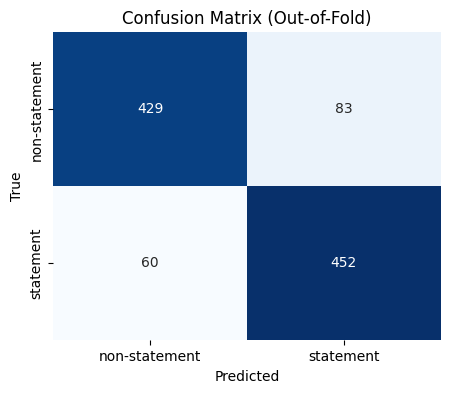

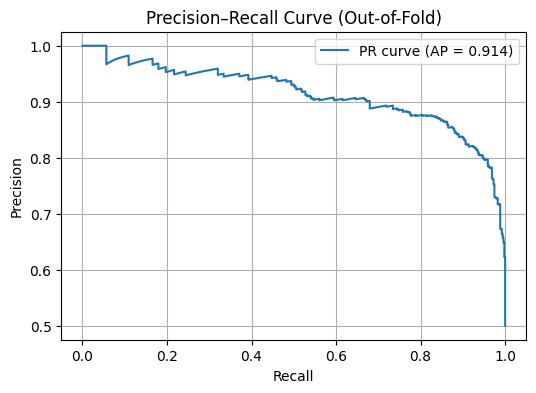

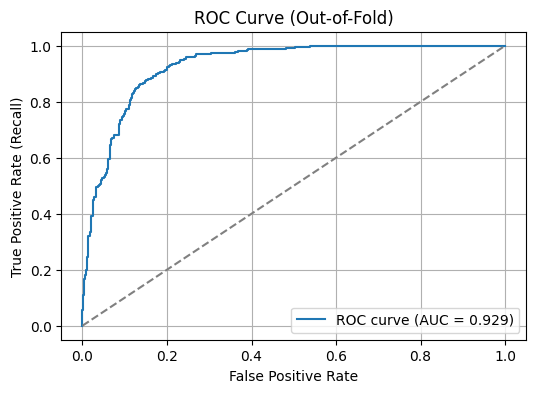

In [ ]:
# Visualising Metrics
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    ConfusionMatrixDisplay, precision_recall_curve, average_precision_score,
    roc_curve, auc
)

# Confusion Matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["non-statement","statement"],
            yticklabels=["non-statement","statement"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Out-of-Fold)")
plt.show()

# Precision-Recall Curve
y_scores = cross_val_predict(mlp, X_combined, y, cv=cv, method="predict_proba")[:,1]
prec, rec, thresh = precision_recall_curve(y, y_scores)
ap = average_precision_score(y, y_scores)

plt.figure(figsize=(6,4))
plt.plot(rec, prec, label=f"PR curve (AP = {ap:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (Out-of-Fold)")
plt.legend()
plt.grid(True)
plt.show()

# ROC Curve
fpr, tpr, thresh = roc_curve(y, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0,1],[0,1],"--", color="grey")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve (Out-of-Fold)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [ ]:
# Save the trained model
mlp.fit(X_combined, y)
joblib.dump(
    {"model": mlp, "scaler": scaler, "feature_cols": feature_cols},
    "MLP_statement_segmenter.joblib"
)


['MLP_statement_segmenter.joblib']